## Семинар 9: "LSTM"

ФИО: Перфильева Нелли Андреевна

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from tqdm import tqdm
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output
import sys
from torch.utils.data import DataLoader, Dataset, TensorDataset
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

In [3]:
def train_network(network, train_loader, epochs, learning_rate, hidden_size, loss, plot=True,
          device='cpu', verbose=True):
    loss = loss
    train_loss_epochs = []
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    # logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    try:
        for epoch in tqdm(range(epochs)):
            losses = []
            for X, y in train_loader:
                X = X.type(dtype = torch.FloatTensor)
                X = X.to(device)
                y = y.to(device)
                hidden = (torch.zeros(1, 1, network.hidden_size).to(device),
                        torch.zeros(1, 1, network.hidden_size).to(device))
                prediction, _ = network(X, hidden)
                loss_batch = loss(y.to(device), prediction.to(device))
                network.zero_grad()
                losses.append(loss_batch.cpu().item())
                loss_batch.backward()
                optimizer.step()
            train_loss_epochs.append(np.mean(losses))
            clear_output(True)
            sys.stdout.write('\rEpoch {0}... (Train) LOSS: {1:.3f}'.format(
                            epoch, train_loss_epochs[-1]))
        if plot:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid('on')
            plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

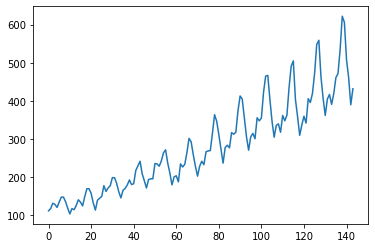

In [35]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [36]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [37]:
len(dataset)

144

In [38]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


96 48


In [39]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [46]:
# Пример подготовленных данных

look_back = 7
look_forward=1
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [47]:
len(train)

96

In [48]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))

In [49]:
train_dataloader =  DataLoader(train_dataset, batch_size=5)

In [50]:
test_dataset = TensorDataset(torch.from_numpy(testX), torch.from_numpy(testY))


In [51]:
test_dataloader =  DataLoader(test_dataset, batch_size=5)


100%|██████████| 500/500 [00:26<00:00, 18.53it/s]

Epoch 499... (Train) LOSS: 0.004

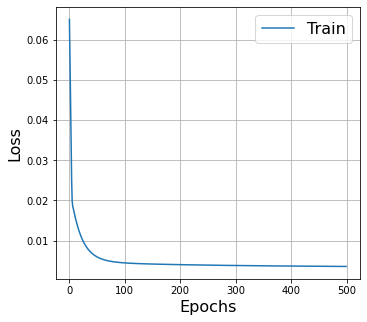

In [66]:
my_model =  LSTM(hidden_size=10, input_size=look_back)
loss_2 = train_network(my_model, train_dataloader, 500, 0.001, 5, loss=nn.MSELoss())


In [67]:
def predict(model, hidden_size, device = 'cpu'):
    hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
              torch.ones(1, 1, model.hidden_size).to(device))
    predicted = []
    model.to(device)
    model.zero_grad()
    for X, y in test_dataloader:
        X = X.to(device)
        y_pred, hidden = model(X, hidden)
        predicted += list(y_pred[:, 0, 0])
    return predicted
        

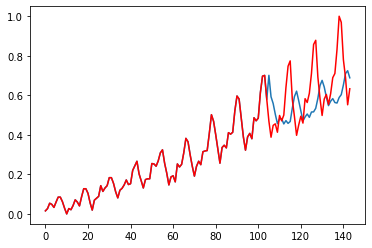

In [68]:
y_pred = predict(my_model, look_forward, 'cpu')

prediction = np.hstack((train[:, 0], test[:, 0]))
prediction[-len(y_pred):] = [i.item() for i in y_pred]

plt.plot(prediction)
plt.plot(dataset, "r")

## Задание 3 

Поучаствуйте в соревновании https://www.kaggle.com/t/db8f882eee2b4fbd9936a8c51b62245c 

Для зачета задания нужно получить значение MAPE меньше 0.2

До 3 декабря 2021 можно получить 3,2,1 дополнительных балла за 1, 2 и 3 место соответственно.


Опиционально: сравните классические подходы (ARIMA, gradient boosting trees и RNN)

$\bf{ Файл }$ time-series-prediction-technosphere-fall-2021-final.ipynb

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: